In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

# 4.5규제가 있는 선형 모델
- Overfitting을 방지하기 위해 모델을 규제하는 것
- 선형 회귀 모델에서는 가중체를 제한함으로써 규제를 가한다

### 4.5.1 릿지 회귀 Ridge regression
- L2 regression
- 비용함수에 규제항이 추가된 선형 회귀 모델
$$J(\theta)=MSE(\theta)+\alpha{1\over 2} \sum_{i=1}^n{\theta_i^2}$$
- 규제는 비용함수에 추가되기 때문에 테스트세트에서 성능을 평가하거나 실제 샘플을 예측할 때 포함되지 않는다
- 릿지 회귀는 입력 특성의 스케일에 민감하기 때문에 데이터의 스케일을 맞춰주는 것이 중요
- $\alpha$가 증가할수록 모델의 분산은 줄지만 편향은 커진다 (규제가 커진다)
- 릿지회귀를 계산하기 위해 정규방정식을 사용할 수 있다. A는 단위행렬에서 첫번째 원소만 1로 바꾼 것
$$ \hat{\theta}=(X^T \cdot X+\alpha A)^{-1} \cdot X^T \cdot y$$

In [29]:
from sklearn.linear_model import Ridge
ridge_reg=Ridge(alpha=1,solver="cholesky")
ridge_reg.fit(X,y)
print(ridge_reg.predict([[1.5]]))

[[1.55071465]]


In [45]:
from sklearn.linear_model import SGDRegressor
sgd_reg=SGDRegressor(penalty='l2')
sgd_reg.fit(X,y.flatten())
print(sgd_reg.predict([[1.5]]))

[1.465506]


### 4.5.2 라쏘 회귀 Lasso Regression
- L1 regression
- 비용함수에 규제항이 추가된 선형 회귀 모델
$$J(\theta)=MSE(\theta)+\alpha \sum_{i=1}^n{\left\vert \theta_i \right\vert}$$
- 덜 중요한 특성의 가중치를 완전히 제거하려고 한다(0으로 만든다)
- $\alpha$가 커질수록 다항회귀 곡선은 차수가 줄어들어 직선에 가까워진다. 죽 고차항의 계수를 삭제한다
- 즉, 라쏘 회귀는 자동으로 특성 선택을 하고 희소 모델을 만든다.
- 라쏘의 비용함수는 0에서 미분 불가능하지만 subgradient vector를 사용하면 경사하강법을 사용할 수 있다.

In [31]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

In [44]:
sgd_reg=SGDRegressor(penalty='l1')
sgd_reg.fit(X,y.flatten())
print(sgd_reg.predict([[1.5]]))

[1.46819507]


#### 릿지 회귀와 라쏘 회귀를 이용한 다항 회귀

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

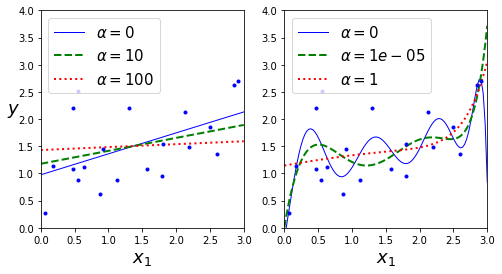

In [35]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

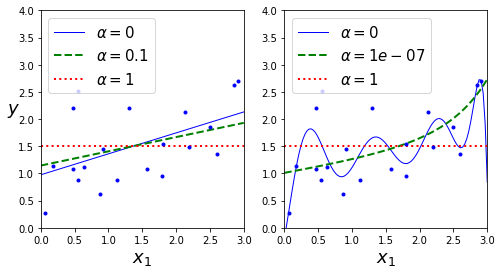

In [36]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

plt.show()

### 4.5.3 엘라스틱넷 Elastic net
- 릿지회귀와 라쏘회귀를 절충한 모델
$$J(\theta)=MSE(\theta)+r\alpha \sum_{i=1}^n{\left\vert \theta_i \right\vert}+(1-r)\alpha{1\over 2} \sum_{i=1}^n{\theta_i^2}$$

In [41]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

In [43]:
sgd_reg=SGDRegressor(penalty='elasticnet')
sgd_reg.fit(X,y.flatten())
print(sgd_reg.predict([[1.5]]))

[1.47178611]


### 4.5.4 조기종료 early stopping
- 검증 에러가 최소값에 도달하면 훈련을 중지시키는 것
- 감소하던 검증에러가 상승하면 모델이 훈련세트에 과대적합 되었다는 의미

In [57]:
import warnings
warnings.filterwarnings(action='ignore')

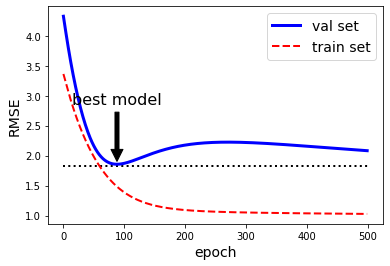

In [60]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="train set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)

plt.show()

In [61]:
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 이어서 학습합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [62]:
best_epoch, best_model

(88,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=True))